# Importing the dependencies

In [1]:
import os
import keras
import tensorflow as tf
import tensorflow.keras.backend as K
import matplotlib.pyplot as plt
import sys
import pickle
import string
import numpy as np

In [2]:
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.xception import preprocess_input
from tensorflow.keras.models import Model
from pickle import load
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM, GRU
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout, Reshape, Lambda, Concatenate
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import optimizers
from nltk.translate.bleu_score import corpus_bleu

emb_dim = 50
batch_size = 32
snapshot_folder = '/kaggle/input/weights-image/'

## Defining the Progress Bar

In [3]:
def progressBar(value, endvalue, bar_length=20, job='Job'):
    percent = float(value) / endvalue
    arrow = '-' * int(round(percent * bar_length) - 1) + '>'
    spaces = ' ' * (bar_length - len(arrow))
    
    sys.stdout.write("\r{0} Completion: [{1}] {2}%".format(job, arrow + spaces, int(round(percent * 100))))
    sys.stdout.flush()

## Loading Functions

In [4]:
def load_doc(filename):
    file = open(filename, 'r')
    text = file.read()
    file.close()
    return text

In [5]:
def load_set(filename):
    doc = load_doc(filename)
    dataset = list()
    # process line by line
    for line in doc.split('\n'):
        # skip empty lines
        if len(line) < 1:
            continue
        # get the image identifier
        identifier = line.split('.')[0]
        dataset.append(identifier)
    return list(set(dataset))

In [6]:
def load_photo_features(filename, dataset):
    # load all features
    all_features = load(open(filename), 'rb')
    # filter features
    features = {k: all_features[k] for k in dataset}
    return features

## Download Dataset with Captions

In [7]:
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip
!wget -q https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip
!unzip -qq Flickr8k_Dataset.zip
!unzip -qq Flickr8k_text.zip
!rm Flickr8k_Dataset.zip Flickr8k_text.zip

## Reading the captions

In [8]:
doc = load_doc('/kaggle/working/Flickr8k.token.txt')

In [9]:
descriptions = {}
for line in doc.split('\n'):
    try:
        tokens = line.split()
        image_id, image_desc = tokens[0], tokens[1:]
        
        # Extract filename from image_id
        image_id = image_id.split('.')[0]
        
        # Convert description tokens back to string
        image_desc = ' '.join(image_desc)
        if image_id not in descriptions:
            descriptions[image_id] = list()
        descriptions[image_id].append(image_desc)
    except:
        print(line)

1000268201_693b08cb0e ['A child in a pink dress is climbing up a set of stairs in an entry way .', 'A girl going into a wooden building .', 'A little girl climbing into a wooden playhouse .', 'A little girl climbing the stairs to her playhouse .', 'A little girl in a pink dress going into a wooden cabin .']


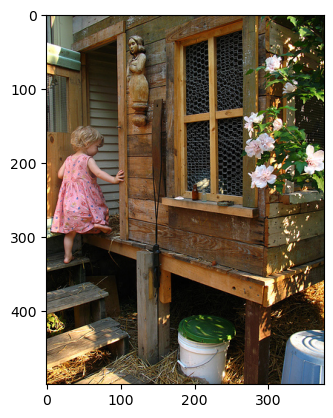

In [10]:
print(next(iter(descriptions)), descriptions[next(iter(descriptions))])

x = plt.imread('/kaggle/working/Flicker8k_Dataset/' + next(iter(descriptions)) + '.jpg')
plt.imshow(x)
plt.show()

## Cleaning the data

In [11]:
def clean_data(pairs):
    # Prepare translation table for removing punctuation
    table = str.maketrans('', '', string.punctuation)
    for key, desc_list in descriptions.items():
        for i in range(len(desc_list)):
            desc = desc_list[i]
            # Tokenize
            desc = desc.split()
            # Convert to lowercase
            desc = [word.lower() for word in desc]
            # Remove punctuation from each token
            desc = [w.translate(table) for w in desc]
            # Remove hanging 's' and 'a'
            desc = [word for word in desc if len(word) > 0]
            # Remove tokens with numbers in them
            desc = [word for word in desc if word.isalpha()]
            # Store as string
            desc_list[i] = ' '.join(desc)
    return descriptions

In [12]:
descriptions_clean = clean_data(descriptions)
descriptions[next(iter(descriptions_clean))]

['a child in a pink dress is climbing up a set of stairs in an entry way',
 'a girl going into a wooden building',
 'a little girl climbing into a wooden playhouse',
 'a little girl climbing the stairs to her playhouse',
 'a little girl in a pink dress going into a wooden cabin']

## Adding start and end token to the sequence of words

In [13]:
start_token = '<start>'
end_token = '<end>'

def add_end_start_tokens(descriptions):
    for key in descriptions:
        for i in range(len(descriptions[key])):
            descriptions[key][i] = start_token + ' ' + descriptions[key][i] + ' ' + end_token
    return descriptions

In [14]:
descriptions_tokenSE = add_end_start_tokens(descriptions_clean)
descriptions_tokenSE[next(iter(descriptions_tokenSE))]

['<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>',
 '<start> a girl going into a wooden building <end>',
 '<start> a little girl climbing into a wooden playhouse <end>',
 '<start> a little girl climbing the stairs to her playhouse <end>',
 '<start> a little girl in a pink dress going into a wooden cabin <end>']

## Loading train captions

In [15]:
def load_train_test(descriptions, dataset):
    dataset_ = {}
    for image_id in dataset:
        dataset_[image_id] = descriptions[image_id]
    
    return dataset_

In [16]:
train_imgs_addr = '/kaggle/working/Flickr_8k.trainImages.txt'
test_imgs_addr = '/kaggle/working/Flickr_8k.testImages.txt'
dev_imgs_addr = '/kaggle/working/Flickr_8k.devImages.txt'

train_imgs_names = load_set(train_imgs_addr)
test_imgs_names = load_set(test_imgs_addr)
dev_imgs_names = load_set(dev_imgs_addr)

len(train_imgs_names), len(test_imgs_names), len(dev_imgs_names)

(6000, 1000, 1000)

In [17]:
train_descriptions = load_train_test(descriptions_tokenSE, train_imgs_names)
dev_descriptions = load_train_test(descriptions_tokenSE, dev_imgs_names)
test_descriptions = load_train_test(descriptions_tokenSE, test_imgs_names)